In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_period,koi_sma,koi_smass&format=csv"
df_kepler = pd.read_csv(data_url)

In [3]:
nans_per_col = df_kepler.isna().sum(axis=0)
nans_per_col

,0
koi_period,0
koi_sma,363
koi_smass,363


In [4]:
df_kepler_clean = df_kepler.dropna().reset_index(drop=True)
df_kepler_clean

,koi_period,koi_sma,koi_smass
0,9.488036,0.0853,0.919
1,54.418383,0.2734,0.919
2,19.899140,0.1419,0.961
3,1.736952,0.0267,0.836
4,2.525592,0.0374,1.095
...,...,...,...
9196,0.527699,0.0128,1.005
9197,1.739849,0.0290,1.075
9198,0.681402,0.0157,1.104
9199,333.486169,1.2233,2.190


In [5]:
df_kepler_clean.corr()

,koi_period,koi_sma,koi_smass
koi_period,1.000000,0.871817,-0.004991
koi_sma,0.871817,1.000000,0.058292
koi_smass,-0.004991,0.058292,1.000000


Text(0.5, 1.0, 'Pearson Correlation Table')

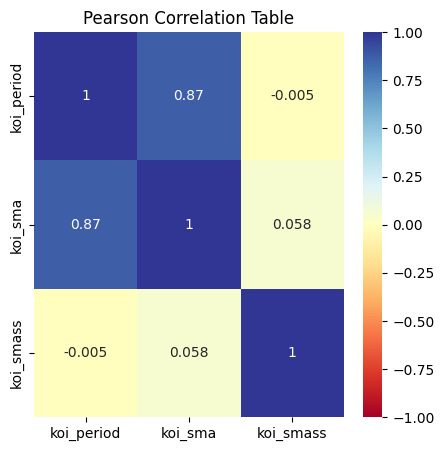

In [6]:
plt.figure(figsize=(5,5))
ax=sns.heatmap(df_kepler_clean.corr(), vmin=-1, vmax=1,annot=True, cmap="RdYlBu")
ax.set_title("Pearson Correlation Table")

In [7]:
def filter(df,col,iqr_score):
  iqr_col=df[col].quantile(0.75)-df[col].quantile(0.25)
  filter_lower=df[col]>df[col].quantile(0.25)-(iqr_col*iqr_score)
  filter_upper=df[col]<df[col].quantile(0.75)+(iqr_col*iqr_score)
  return df[filter_lower & filter_upper]

In [8]:
df_k1=filter(df_kepler_clean,"koi_smass",2)
df_k2=filter(df_k1,"koi_sma",2)
df_k3=filter(df_k2,"koi_period",2)
df_k4=df_k3.copy()

In [9]:
df_k4["ln_mass"]=(df_k3["koi_smass"].apply(lambda x: x*1.98847*10**(30))).apply(np.log)
df_k4["ln_axis"]=(df_k3["koi_sma"].apply(lambda x: x*1.49597870700*10**(11))).apply(np.log)
df_k4["ln_period"]=(df_k3["koi_period"].apply(lambda x: x*86400)).apply(np.log)

In [10]:
df_k5=df_k4.drop(["koi_smass","koi_sma","koi_period"],axis=1)

In [11]:
df_k5.head()

,ln_mass,ln_axis,ln_period
0,69.680449,23.269636,13.616775
1,69.680449,24.434397,15.363445
2,69.725137,23.778584,14.357419
3,69.585792,22.108125,11.918875
4,69.855673,22.445132,12.293218


Text(0.5, 1.0, 'Pearson Correlation Table')

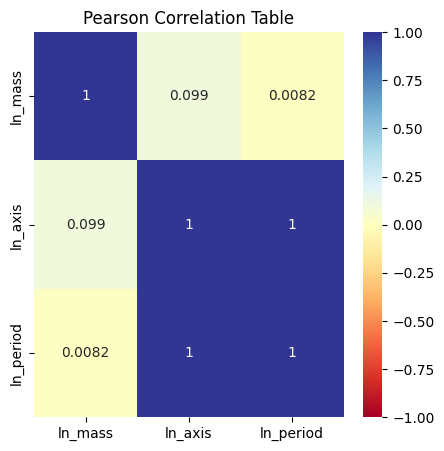

In [12]:
plt.figure(figsize=(5,5))
ax=sns.heatmap(df_k5.corr(), vmin=-1, vmax=1,annot=True, cmap="RdYlBu")
ax.set_title("Pearson Correlation Table")

In [13]:
X=df_k5[['ln_axis', 'ln_period']]
Y=df_k5['ln_mass']

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.3,shuffle=True)

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [18]:
lr.coef_

array([ 2.93630332, -1.95780402])

In [19]:
log_const=lr.intercept_
log_const

28.012517593453964

In [20]:
lr.score(X_test,y_test)

0.9990471513802122

In [21]:
ln_mass_pred=lr.predict(X)

Text(0, 0.5, 'log(M)')

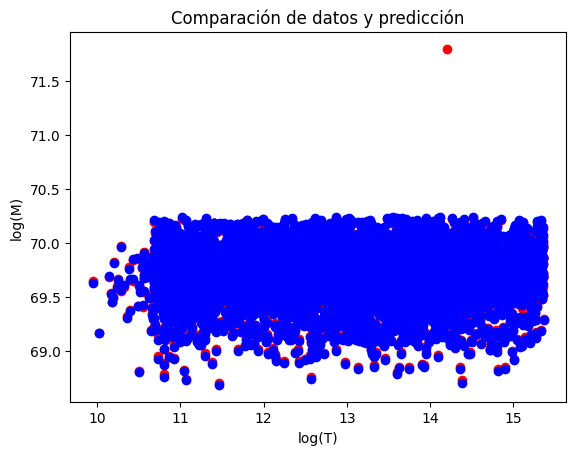

In [22]:
plt.scatter(X['ln_period'],ln_mass_pred, c='r')
plt.scatter(X['ln_period'],Y, c='b')
plt.title('Comparación de datos y predicción')
plt.xlabel('log(T)')
plt.ylabel('log(M)')

In [23]:
from sklearn.model_selection import cross_validate

In [24]:
scores_1=cross_validate(lr,X,Y,scoring='r2')
scores_1

{'fit_time': array([0.02587771, 0.0192101 , 0.00443435, 0.00892425, 0.01064348]),
 'score_time': array([0.04111457, 0.00352001, 0.00303555, 0.00319004, 0.00348449]),
 'test_score': array([0.99897863, 0.99900445, 0.99918332, 0.9373306 , 0.99909247])}

In [25]:
print(f'Puntuación del modelo de regresión lineal: {scores_1["test_score"].mean():.3f} +/- {scores_1["test_score"].std():.3f}')

Puntuación del modelo de regresión lineal: 0.987 +/- 0.025


In [26]:
import tensorflow as tf

layer0=tf.keras.layers.Dense(units=1, input_dim=2,activation='linear')
model=tf.keras.Sequential([layer0])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.2),metrics=['mean_squared_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
history=model.fit(X_train,y_train ,epochs=100,verbose=True,validation_split=0.01)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1914.2301 - mean_squared_error: 1914.2301 - val_loss: 16.6366 - val_mean_squared_error: 16.6366
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.1538 - mean_squared_error: 15.1538 - val_loss: 14.6069 - val_mean_squared_error: 14.6069
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 13.6686 - mean_squared_error: 13.6686 - val_loss: 12.4124 - val_mean_squared_error: 12.4124
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11.8407 - mean_squared_error: 11.8407 - val_loss: 10.7160 - val_mean_squared_error: 10.7160
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6016 - mean_squared_error: 9.6016 - val_loss: 9.3378 - val_mean_squared_error: 9.3378
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.7890 - mean_squared_error: 7.7890 - val_loss: 6.4522 - val_mean_squared_error: 6.4522
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9073 - mean_squared_err

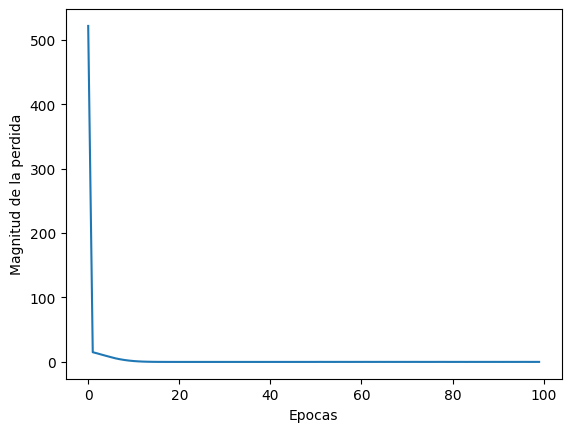

In [28]:
plt.plot(history.history['loss'])
plt.xlabel('Epocas')
plt.ylabel('Magnitud de la perdida')
plt.show()

In [29]:
from sklearn.metrics import r2_score

y_pred=model.predict(X_test)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
r2_score(y_test,y_pred)

0.7947572304783067

In [31]:
layer0.get_weights()

[array([[ 3.9382405],
        [-2.624296 ]], dtype=float32),
 array([13.693345], dtype=float32)]

In [32]:
# Log(C)= Log(M)-3*Log(a)+2*Log(T)
#G= 4*pi**2/C

wt=[1.0,-3.0, 2.0]
log_c=df_k5.iloc[:,:].mul(wt, axis=1).sum(axis=1)
g_const=log_c.apply(lambda x: 4*np.pi**2/np.exp(x))

In [33]:
g_const[0]

6.679876274655611e-11

In [34]:
g_const.min()

6.359525666557502e-11

In [35]:
g_const.max()

6.013451810935543e-10

In [36]:
g_filtered=g_const[g_const < 1e-10]

In [37]:
len(g_const)-len(g_filtered)

1

[Text(0, 0.5, 'Frecuencia')]

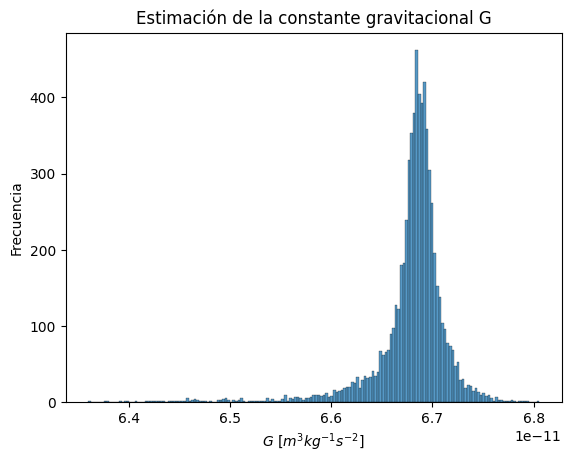

In [38]:
ax=sns.histplot(g_filtered)
ax.set_title('Estimación de la constante gravitacional G')
ax.set(xlabel=r'$G$ $[m^3 kg^{-1} s^{-2}]$')
ax.set(ylabel='Frecuencia')

In [39]:
g_filtered.skew(), g_filtered.kurtosis()

(0.0, 0.0)

In [40]:
print(f'El estimado de la constante gravitacional es {g_filtered.mean()} +/- {g_filtered.std()}')

El estimado de la constante gravitacional es 6.679399607297097e-11 +/- 3.827745765634631e-13
